In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate
from matplotlib import pyplot as plt
from matplotlib import rcParams
from utils import unit

In [12]:
def UVvis(*args, label):
    in_num = len(args)//2
    assert in_num == len(label), "input data and label must have same length"
    if 'Exp. cyclohexane' in label:
        in_num -= 2
    minx = np.inf
    maxx = -np.inf
    for i in range(in_num):
        if min(args[2*i]) < minx:
            minx = min(args[2*i])
        if max(args[2*i]) > maxx:
            maxx = max(args[2*i])
    x = np.linspace(minx - 25, maxx + 25, 1000)
    y = np.zeros((x.shape[0], in_num))

    def gaussian(x, x0, A, fwhm=20):
        # return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))
        sigma = fwhm / (2*np.sqrt(2*np.log(2)))
        return A * 4.318e6 / x0 * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

    for i in range(in_num):
        for pos, height in zip(args[2*i], args[2*i+1]):
            y[:, i] += gaussian(x, pos, height)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx()
    colors = rcParams["axes.prop_cycle"].by_key()["color"]
    # y *= 5e4  # change it to match experiment
    for i, l, c in zip(range(in_num), label, colors):
        ax.plot(x, y[:, i], color=c, lw=1.5, label=l+r' $\epsilon$')
    if 'Exp. cyclohexane' in label:
        ax.plot(args[-4], args[-3], color=colors[4], lw=1.5, label=label[-2]+r' $\epsilon$')
        ax.plot(args[-2], args[-1], color=colors[3], lw=1.5, label=label[-1]+r' $\epsilon$')
    # peak position
    # for i, c in zip(range(in_num), colors):
    #     for pos, height in zip(args[2*i], args[2*i+1]):
    #         ax.vlines(pos, 0, height, color=c, linestyle="dashed", alpha=0.6)
    for i, (pos, height) in enumerate(zip(args[0], args[1])):
        ax2.vlines(pos, 0, height, color='#1fa7f4', linestyle="dashed", alpha=0.6,
                   label=label[0]+' $f$' if i == 0 else None)  # only for first method 
    ax2.set_ylabel("$f$", fontsize=15)
    # ax2.spines["top"].set_visible(False)
    # ax2.spines["right"].set_visible(False)
    ax2.tick_params(axis="both", which="major", labelsize=15)
    ax2.set_ylim([0, 1.5*np.max(args[1])])

    ax.set_xlim(min(x), max(x))
    # ax.set_ylim(-0.005, 0.3)
    ax.set_xlabel("wavelength (nm)", fontsize=15)
    ax.set_ylabel(r"$\epsilon$", fontsize=15)
    # ax.set_title("Spectrum", fontsize=16)
    # ax.legend(fontsize=15)
    # ax.spines["top"].set_visible(False)
    # ax.spines["right"].set_visible(False)
    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.set_ylim([0, 1.2*np.max(y)])
    ax.grid(True, linestyle="--", alpha=0.5)
    # combine legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, fontsize=15, loc='upper right')

    plt.show()
    fig.savefig('mol_in_solvents_gopt-UVspec' + '.eps', dpi=600, bbox_inches='tight')

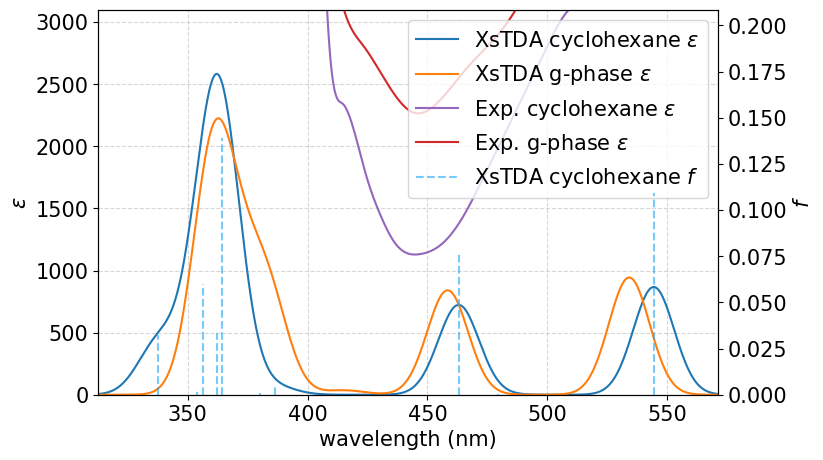

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [13]:
# in .csv file, first column is wavelength (unit is Angstrom), second column oscillator strength in length form
# if first column is energy (unit is eV), use `unit.eVxnm` transform to wavelength. Also energy unit is Hartree can use `unit.ha2eV` transform to eV then transform to wavelength
file = './result/czbtm/'
mol = ''
solvent = 'cyclohexane-'
XsTDA = pd.read_csv(file+mol+solvent+'XsTDAgsol.csv', sep='[,\s]+', header=None, engine='python').to_numpy()
e0 = XsTDA[:10, 0]
os0 = XsTDA[:10, 1]
# e0 = unit.eVxnm / e0
solvent = 'vacuum-'
XTDDFT = pd.read_csv(file+mol+solvent+'XsTDA.csv', sep='[,\s]+', header=None, engine='python').to_numpy()
e1 = XTDDFT[:10, 0]
os1 = XTDDFT[:10, 1]
# e1 = unit.eVxnm / e1
# XTDA = pd.read_csv(file+mol+solvent+'XTDA.csv', sep='[,\s]+', header=None, engine='python').to_numpy()
# e2 = XTDA[:,0]
# os2 = XTDA[:,1]
# # e2 = unit.eVxnm / e2
# UsTDA = pd.read_csv(file+mol+solvent+'UsTDAgsol.csv', sep='[,\s]+', header=None, engine='python').to_numpy()
# e3 = UsTDA[:10, 0]
# os3 = UsTDA[:10, 1]
# UTDDFT = pd.read_csv(file+mol+solvent+'UsTDA.csv', sep='[,\s]+', header=None, engine='python').to_numpy()
# e4 = UTDDFT[:10, 0]
# os4 = UTDDFT[:10, 1]
# UTDA = pd.read_csv(file+mol+solvent+'UTDA.csv', sep='[,\s]+', header=None, engine='python').to_numpy()
# e5 = UTDA[:,0]
# os5 = UTDA[:,1]
solvent = 'cyclohexane-'
experiment = pd.read_csv(file+mol+solvent+'experiment.csv', sep='[,\s]+', header=None, engine='python').to_numpy()
e6 = experiment[:,0]
os6 = experiment[:,1]*1.25e4
int6 = interpolate.interp1d(e6,os6,kind='cubic')
e6 = np.linspace(min(e6), max(e6), 1000)
os6 = int6(e6)
solvent = 'vacuum-'
experiment = pd.read_csv(file+mol+solvent+'experiment.csv', sep='[,\s]+', header=None, engine='python').to_numpy()
e7 = experiment[:,0]
os7 = experiment[:,1]*1e4
int7 = interpolate.interp1d(e7,os7,kind='cubic')
e7 = np.linspace(min(e7), max(e7), 1000)
os7 = int7(e7)
# UVvis(e0, os0, e1, os1, e2, os2, e6, os6, label=['XsTDA', 'XTDDFT', 'XTDA', 'experiment'])
# UVvis(e3, os3, e4, os4, e5, os5, e6, os6, label=['UsTDA', 'UTDDFT', 'UTDA', 'experiment'])
UVvis(e0, os0, e1, os1, e6, os6, e7, os7, label=['XsTDA cyclohexane', 'XsTDA g-phase', 'Exp. cyclohexane', 'Exp. g-phase'])

In [113]:
def UVvis_onemethod(*args, label):
    in_num = len(args)//2
    assert in_num == len(label), "input data and label must have same length"
    minx = np.inf
    maxx = -np.inf
    for i in range(in_num):
        if min(args[2*i]) < minx:
            minx = min(args[2*i])
        if max(args[2*i]) > maxx:
            maxx = max(args[2*i])
    x = np.linspace(minx - 25, maxx + 25, 1000)
    y = np.zeros((x.shape[0], in_num))

    def gaussian(x, x0, A, sigma=20):
        return A * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

    for i in range(in_num):
        for pos, height in zip(args[2*i], args[2*i+1]):
            y[:, i] += gaussian(x, pos, height)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx()
    colors = rcParams["axes.prop_cycle"].by_key()["color"]
    for i, l, c in zip(range(in_num), label, colors):
        ax.plot(x, y[:, i], color=c, lw=1.5, label=l+r' $\epsilon$')
    # peak position
    # for i, c in zip(range(in_num), colors):
    #     for pos, height in zip(args[2*i], args[2*i+1]):
    #         ax.vlines(pos, 0, height, color=c, linestyle="dashed", alpha=0.6)
    for i, (pos, height) in enumerate(zip(args[0], args[1])):
        ax2.vlines(pos, 0, height, color='#1fa7f4', linestyle="dashed", alpha=0.6,
                   label=label[0]+' f' if i == 0 else None)  # only for first method 
    ax2.set_ylabel("f (oscillator strength)", fontsize=15)
    # ax2.spines["top"].set_visible(False)
    # ax2.spines["right"].set_visible(False)
    ax2.tick_params(axis="both", which="major", labelsize=15)
    ax2.set_ylim([0, 1.2*max(args[1])])

    # ax.set_xlim(200, 450)
    # ax.set_ylim(-0.005, 0.3)
    ax.set_xlabel("wavelength (nm)", fontsize=15)
    ax.set_ylabel(r"$\epsilon$", fontsize=15)
    # ax.set_title("Spectrum", fontsize=16)
    # ax.spines["top"].set_visible(False)
    # ax.spines["right"].set_visible(False)
    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.set_ylim([0, 1.2*max(y)])
    ax.grid(True, linestyle="--", alpha=0.5)
    # combine legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, fontsize=15, loc='upper right')

    
    plt.show()
    fig.savefig('mol_in_solvents_gopt-UVspec' + '.svg', dpi=600, bbox_inches='tight')

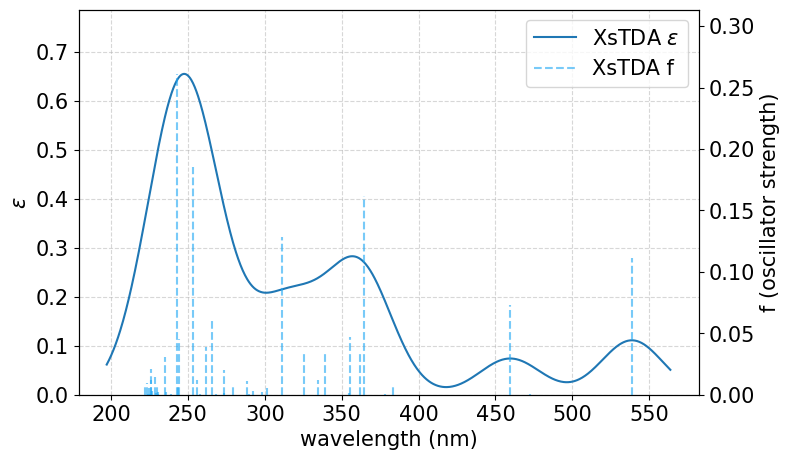

In [31]:
# in .csv file, first column is wavelength (unit is Angstrom), second column oscillator strength in length form
# if first column is energy (unit is eV), use `unit.eVxnm` transform to wavelength. Also energy unit is Hartree can use `unit.ha2eV` transform to eV then transform to wavelength
file = './result/czbtm/'
mol = ''
solvent = 'cyclohexane-'
Xs = pd.read_csv(file+mol+solvent+'XsTDA.csv', sep='[,\s]+', header=None, engine='python').to_numpy()
e1 = Xs[:,0]
os1 = Xs[:,1]
UVvis_onemethod(e1, os1, label=['XsTDA'])

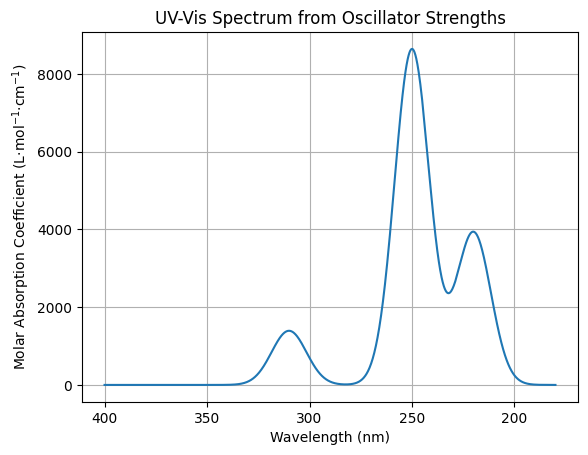

In [11]:
# chatgpt general
import numpy as np
import matplotlib.pyplot as plt

def gaussian(x, mu, fwhm):
    sigma = fwhm / (2*np.sqrt(2*np.log(2)))
    return np.exp(-((x - mu)**2) / (2 * sigma**2))

# 示例激发数据
lambda_i = np.array([220, 250, 310])  # nm
f_i = np.array([0.2, 0.5, 0.1])       # oscillator strengths

# 波长范围
wavelengths = np.linspace(180, 400, 2000)
epsilon = np.zeros_like(wavelengths)

for lam, f in zip(lambda_i, f_i):
    epsilon += 4.318e6 * f / lam * gaussian(wavelengths, lam, fwhm=20)

plt.plot(wavelengths, epsilon)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Molar Absorption Coefficient (L·mol$^{-1}$·cm$^{-1}$)")
plt.title("UV-Vis Spectrum from Oscillator Strengths")
plt.grid(True)
plt.gca().invert_xaxis()  # UV-Vis 光谱常以波长从小到大画
# plt.show()
